-----------------------------------
# 
# **[HW 5](https://github.com/lucamaiano/ADM/tree/master/2022/Homework_5)** - The Marvel Universe!
-----------------------------------

-----------------------------------
##### Download the **data** from [**Kaggle**](https://www.kaggle.com/datasets/csanhueza/the-marvel-universe-social-network?select=hero-network.csv).
-----------------------------------

In [27]:
#pip install itables
#pip install tabulate
#pip install adjustText

In [28]:
import numpy as np
import pandas as pd
import networkx as nx
from tqdm import tqdm
from tabulate import tabulate
import matplotlib.pyplot as plt

from zipfile import ZipFile
from io import BytesIO
import requests

import warnings
warnings.filterwarnings('ignore')

Uploading _csv_files_ from **S3 Bucket** as pandas dataframes named:
 - *hero_net* 
 - *edges* 
 - *nodes*

In [29]:
url = "https://myasw2009bucket.s3.amazonaws.com/HW5_marvel.zip"

buf1 = BytesIO(requests.get(url).content)
with ZipFile(buf1, "r") as f:
    print(" {} files in Zip folder → ".format(len(f.namelist())), f.namelist(),"\n")

    with f.open("hero-network.csv") as file:
        data = pd.read_csv(file)
        print(f.namelist()[1],": shape → ", data.shape)

    with f.open("nodes.csv") as file1:
        nodes = pd.read_csv(file1)
        print(f.namelist()[2],": shape → " ,nodes.shape)
        
    with f.open("edges.csv") as file2:
        edges = pd.read_csv(file2)
        print(f.namelist()[0],": shape → ", edges.shape)

 3 files in Zip folder →  ['edges.csv', 'hero-network.csv', 'nodes.csv'] 

hero-network.csv : shape →  (574467, 2)
nodes.csv : shape →  (19090, 2)
edges.csv : shape →  (96104, 2)


--------------------------------------
## 1. Graphs Set-Up:

### - First graph: 

**Data Preprocessing** :\
Some hero names in **'hero-netowrk.csv'** have **extra spaces** or **extra '/'** at the end of their names\
The hero named 'SPIDER-MAN/PETER PAR'  has been fixed back **'SPIDER-MAN/PETER PARKER'**\
Then entries that have the same hero in both columns have been removed. In the graph, these entries would form a self-loop.

In [30]:
#data = pd.read_csv("datasets/hero-network.csv")

data['hero1'] = data['hero1'].str.rstrip("/").str.rstrip(" ")
data['hero2'] = data['hero2'].str.rstrip("/").str.rstrip(" ")


data.hero1.loc[data['hero1'] == "SPIDER-MAN/PETER PAR"] = "SPIDER-MAN/PETER PARKER"
data.hero2.loc[data['hero2'] == "SPIDER-MAN/PETER PAR"] = "SPIDER-MAN/PETER PARKER"

data.drop(data[data['hero1'] == data['hero2']].index, inplace=True)


data = data.sort_values('hero1')
data = data.reset_index(drop=True)

print(data.shape)
data.head()

(572235, 2)


hero1                 hero2
0  24-HOUR MAN/EMMANUEL       FROST, CARMILLA
1  24-HOUR MAN/EMMANUEL  KILLRAVEN/JONATHAN R
2  24-HOUR MAN/EMMANUEL              M'SHULLA
3  3-D MAN/CHARLES CHAN   SCARLET WITCH/WANDA
4  3-D MAN/CHARLES CHAN  MOCKINGBIRD/DR. BARB

In [31]:
data['tuple'] = data.apply(lambda row: (row['hero1'], row['hero2']), axis=1)
data['tuple'] = data['tuple'].apply(lambda x: tuple(sorted(x)))

pesi = data.groupby(["tuple"])["tuple"].transform("count")

data = data.drop_duplicates(subset=['tuple'])
data['collab'] = pesi

data['weight']=1/data['collab']

print(data.shape)
data.head()

(167100, 5)


hero1                 hero2  \
0  24-HOUR MAN/EMMANUEL       FROST, CARMILLA   
1  24-HOUR MAN/EMMANUEL  KILLRAVEN/JONATHAN R   
2  24-HOUR MAN/EMMANUEL              M'SHULLA   
3  3-D MAN/CHARLES CHAN   SCARLET WITCH/WANDA   
4  3-D MAN/CHARLES CHAN  MOCKINGBIRD/DR. BARB   

                                          tuple  collab  weight  
0       (24-HOUR MAN/EMMANUEL, FROST, CARMILLA)       1     1.0  
1  (24-HOUR MAN/EMMANUEL, KILLRAVEN/JONATHAN R)       1     1.0  
2              (24-HOUR MAN/EMMANUEL, M'SHULLA)       1     1.0  
3   (3-D MAN/CHARLES CHAN, SCARLET WITCH/WANDA)       1     1.0  
4  (3-D MAN/CHARLES CHAN, MOCKINGBIRD/DR. BARB)       1     1.0

**Building the first graph :**

This graph is desired to be **weighted** and **undirected**.\
Here heroes are linked to heroes and an edge between two heroes can be found if they have appeared in the same comic together.
 
To get the edges of the graph, for each row of the *hero-network.csv* we created a sorted tuple (sorted in alphabetical order) containing (**Hero_1**,**Hero_2**).\
We grouped the tuples and counted the number of times each tuple appears in the dataframe.\
This is the number of collaborations between the two heroes and it is stored in a new column named 'collab'.

The **'weight' column** contains $\frac{1}{\text{n of collab}}$ between the two heroes.

Now we add the 'weight' column and the 'collab' column as attributes of the edges.

In [32]:
G_hero = nx.from_pandas_edgelist(data, 'hero1', 'hero2', create_using = nx.Graph(), edge_attr=['weight', 'collab'])
print(nx.info(G_hero))

Graph with 6421 nodes and 167100 edges


In [33]:
print("\n - edge between {} and {} --> {}".format("CAPTAIN AMERICA", "IRON MAN",
                                     G_hero.edges()[("IRON MAN/TONY STARK","CAPTAIN AMERICA")]))

print(" - edge between {} and {} --> {}".format("CAPTAIN AMERICA","SPIDER-MAN", 
                                     G_hero.edges()[("CAPTAIN AMERICA","SPIDER-MAN/PETER PARKER")]))

print(" - edge between {:>8} and {:>11} --> {}\n".format("IRON MAN","SPIDER-MAN", 
                                     G_hero.edges()[("IRON MAN/TONY STARK","SPIDER-MAN/PETER PARKER")]))


 - edge between CAPTAIN AMERICA and IRON MAN --> {'weight': 0.002242152466367713, 'collab': 446}
 - edge between CAPTAIN AMERICA and SPIDER-MAN --> {'weight': 0.006896551724137931, 'collab': 145}
 - edge between IRON MAN and  SPIDER-MAN --> {'weight': 0.010638297872340425, 'collab': 94}



--------------------------------------

### - Second graph: 
**Data Preprocessing :**\
The type of node ('hero' or 'comic') can be found in *'nodes.csv'*.\
Some heroe's names in **'nodes.csv'** have **extra spaces** or **extra '/'** at the end of their names\
and the hero name **'SPIDER-MAN/PETER PARKER'** was misspelled as "SPIDER-MAN/PETER PARKERKER"

In [34]:
## nodes = pd.read_csv("datasets/nodes.csv")

nodes['node']=nodes['node'].apply(lambda x : x.rstrip("/").rstrip(" "))
#nodes["node"] = nodes['node'].str.rstrip("/").str.rstrip(" ")

nodes.node.loc[nodes['node'] == "SPIDER-MAN/PETER PARKERKER"] = "SPIDER-MAN/PETER PARKER"
nodes.head()

node   type
0               2001 10  comic
1                2001 8  comic
2                2001 9  comic
3  24-HOUR MAN/EMMANUEL   hero
4  3-D MAN/CHARLES CHAN   hero


From **edges.csv** an edge between a hero node and a comic node can be found when the hero has appeared in that specific comic.\
Some heroe's names in *'edges.csv'* have **extra spaces** or **extra '/'** at the end of their names

In [35]:
## edges = pd.read_csv("datasets/edges.csv")

edges['hero']=edges['hero'].apply(lambda x : x.rstrip("/").rstrip(" "))
#edges["hero"] = edges['hero'].str.rstrip("/").str.rstrip(" ")

edges.head()

hero   comic
0  24-HOUR MAN/EMMANUEL  AA2 35
1  3-D MAN/CHARLES CHAN   AVF 4
2  3-D MAN/CHARLES CHAN   AVF 5
3  3-D MAN/CHARLES CHAN   COC 1
4  3-D MAN/CHARLES CHAN  H2 251

**Building the second graph :**

This graph is desired to be **undirected** and **unweighted**.\
We start by creating an **empty graph** and adding **nodes** with their attributes ("hero" or "comic")


In [36]:
G = nx.Graph()    # build an empty Graph

G.add_nodes_from([x, {"type": y}] for x,y in zip(nodes.node, nodes.type))  # add nodes from nodes.csv 
                                                                           # with 'type' of the node as attribute

print("\nCAPTAIN AMERICA → ", G.nodes["CAPTAIN AMERICA"])
print("IRON MAN  →  ", G.nodes["IRON MAN/TONY STARK"])
print("AVF 4   → ", G.nodes["AVF 4"], "\n")


CAPTAIN AMERICA →  {'type': 'hero'}
IRON MAN  →   {'type': 'hero'}
AVF 4   →  {'type': 'comic'} 



Secondly, we add the **edges** to the graph :

In [37]:
G.add_edges_from([(x,y) for x,y in zip(edges.hero, edges.comic)])  # add edges to the Graph

G.remove_node("CURRY/MAJOR MERCURY/")

print(nx.info(G))

Graph with 19087 nodes and 96103 edges


In the column 'comic' of the *edges.csv dataset*, **"CURRY/MAJOR MERCURY/"** appears as a comic.\
It is not a comic but a notable aliases of the character **MAKKARI** and it does not appear in the *nodes.csv dataset*\
so we dropped the node.

In [38]:
edges[edges['comic'].str.contains('CURRY/MAJOR MERCURY/')]

hero                 comic
49111  MAKKARI/MIKE KHARY/I  CURRY/MAJOR MERCURY/

-------------------

## 2. Backend Implementation

### Finding the top N Heroes

- **For Graph 1** :\
For the first graph, **top superheroes** are found considering the **degree of centrality** of their **node**.\
Here is shown a table presenting the top 5 heroes for graph 1:

In [39]:
degreeC_dict = nx.degree_centrality(G_hero)

top_5 = sorted(degreeC_dict.items(), key=lambda item: item[1], reverse =True)[:5]
top_5 = [(t[0].split("/")[0], round(t[1], 5)) for t in top_5]

print(tabulate(top_5, headers=["top Heros", "degree_Cent"], tablefmt="fancy_grid", numalign='center', stralign="center"))

╒═════════════════╤═══════════════╕
│    top Heros    │  degree_Cent  │
╞═════════════════╪═══════════════╡
│ CAPTAIN AMERICA │    0.29642    │
├─────────────────┼───────────────┤
│   SPIDER-MAN    │    0.27056    │
├─────────────────┼───────────────┤
│    IRON MAN     │    0.23692    │
├─────────────────┼───────────────┤
│      THING      │    0.22056    │
├─────────────────┼───────────────┤
│  MR. FANTASTIC  │    0.21449    │
╘═════════════════╧═══════════════╛


Make a function that returns a **sub-graph** with only the **top hero nodes** that should be considered:

In [40]:
def find_top1(grafo, k):
    
    degreeC_dict = nx.degree_centrality(grafo)
    top = sorted(degreeC_dict.items(), key=lambda item: item[1], reverse =True)[:k]
    s_g = grafo.subgraph([i[0] for i in top])
    print("  sub-{}\n".format(nx.info(s_g)))
    return s_g

s = find_top1(G_hero, 15)

  sub-Graph with 15 nodes and 105 edges



- **For Graph 2** :\
To select the **top heroes** we count their **appearances** in the *'hero'* column in **eges.csv**\
Here a list of the top 5 heroes for graph 2:

In [41]:
x = edges.groupby(['hero'])['hero'].size().sort_values(ascending=False).head(5)
x = list(zip([j[0] for j in x.index.str.split("/")],x))

print(tabulate(x, headers=["top Heros", "Appearances"], tablefmt="fancy_grid", numalign='center', stralign="center"))

╒═════════════════╤═══════════════╕
│    top Heros    │  Appearances  │
╞═════════════════╪═══════════════╡
│   SPIDER-MAN    │     1577      │
├─────────────────┼───────────────┤
│ CAPTAIN AMERICA │     1334      │
├─────────────────┼───────────────┤
│    IRON MAN     │     1150      │
├─────────────────┼───────────────┤
│      THING      │      963      │
├─────────────────┼───────────────┤
│      THOR       │      956      │
╘═════════════════╧═══════════════╛


Also for **Graph 2** building a function that returns a **sub-graph** with only the <u> top hero nodes and related comics</u> that should be considered.\
In this regard we have decided to **remove** the **comic nodes** with a **degree equal to one**.\
These are comics tied to a single hero. 
The main reason is that we are interested in **connections** and **collaborations** between heroes and furthermore they also hinder the visualization of the graph.

In [42]:
def top_hero_from_graph2(data, Graph, k: int, p=None):

    top = data.groupby(['hero'])['hero'].size().sort_values(ascending=False).head(k)
    links = data.loc[data['hero'].isin(top.keys())]
    edg = list(links.apply(lambda row: (row['hero'], row['comic']), axis=1))
    s_g = nx.edge_subgraph(Graph, edg)
    #print("  sub-{}".format(nx.info(s_g)))
    nodesComics = [x for x,y in s_g.nodes(data=True) if y["type"]=="comic"]
    result = [node for node in nodesComics if s_g.degree(node) > 1 ]
    new_graph = s_g.subgraph(result + list(top.keys()))
    if p is not None:
        print("  sub-{}".format(nx.info(new_graph)))
    
    return new_graph, top

-------------------------------------------
### Functionality 1 - Extract the graph's Features:

Input:

- graph data
- graph type (ex., number 1 or number 2)
- N --> denoting the top N heroes that their data should be considered

Expected output:

- The **number of nodes** in the network (if <u>type 2</u>, report for both node types)
- The **number of collaborations** of each superhero with the others (only if <u>type 1</u>)
- The number of **heroes** that have **appeared** in each **comic** (only if <u>type 2</u>)
- The **network's density**
- The network's **degree distribution**
- The **average degree** of the **network**
- The **network's Hubs** (hubs are nodes having degrees more extensive than the 95th percentile of the degree distribution)
- Whether the Network is **sparse or dense**

In [43]:
def funzione_1():
    
    print(" ")
    graph_type = int(input(" - Graph type (1 or 2) : "))
    top_N = int(input(" - Top N heroes that should be considered : "))
    info = [ ["Number of Nodes", "Density of the Network", "Average Degree of the Network", "is Sparse or Dense"] ]
    print(" ")
    
    if graph_type == 1:
        
        sub_graph = find_top1(G_hero, top_N )
        
        n_nodes = len(sub_graph.nodes)                      # number of nodes in the sub network
        density = nx.density(sub_graph)                     # sub network's density
        average_degree = sum([sub_graph.degree[i] for i in sub_graph.nodes])/len(sub_graph.nodes)  # average degree 
        s_or_d  = "Sparse" if density < 0.5 else "Dense"                                                 #of the network
        
        info.append([n_nodes, round(density, 3), round(average_degree, 3), s_or_d] ) 
        print(tabulate(info, headers="firstrow", tablefmt="fancy_grid", numalign='center', stralign="center"))
        
        
        ## Finding the number of collaborations of each superhero with the others :
        
        lista = []
        for i in sub_graph.nodes:
            apparizioni = sum([x[2] for x in sub_graph.edges(i, data="collab")])
            lista.append((i, apparizioni))
        lista = sorted(lista, key=lambda tup: tup[1], reverse=True)
        
        # Degree Distribution:
        
        dist = [(hero, sub_graph.degree(hero)) for hero in sub_graph.nodes()]
        
        # Finding Hubs:
        
        soglia = np.percentile([x[1] for x in dist], 0.95)
        hubs = [(x[0],x[1]) for x in dist if x[1] >= soglia]
        
        return sub_graph, info, lista, hubs, dist
    
    if graph_type == 2:
        
        sub_graph, top = top_hero_from_graph2(edges, G, top_N, p= True)
        
        n_nodes = len(sub_graph.nodes)        # number of nodes in the sub network
        density = nx.density(sub_graph)       # sub network's density
        average_degree = sum([sub_graph.degree[i] for i in sub_graph.nodes])/len(sub_graph.nodes)     # average degree of the network
        s_or_d  = "Sparse" if density < 0.5 else "Dense"
        
        info.append([n_nodes, round(density, 3), round(average_degree, 3), s_or_d] ) 
        print(tabulate(info, headers="firstrow", tablefmt="fancy_grid", numalign='center', stralign="center"))
        
        # Finding the number of heroes that have appeared in each comic:
        
        selected_nodes = [n for n,v in sub_graph.nodes(data=True) if v['type'] == 'hero'] 
        degreeC_dict = nx.degree_centrality(sub_graph)
        top = sorted(degreeC_dict.items(), key=lambda item: item[1], reverse =True)[:25+top_N]
        top_comics = [x for x in top if x[0] not in selected_nodes]
        heroes_in_comic = [ (node[0], sub_graph.degree(node[0]) ) for node in top_comics ]

        # Finding Hubs second graph:
        
        h, a = nx.hits(sub_graph, max_iter=1000)
        h = sorted(h.items(), key=lambda x:x[1], reverse= True)
        h = [(x[0],(round(x[1], 6))) for x in h]
        soglia  = np.quantile(np.array([x[1]for x in h]), 0.95)
        hubs = [(x[0],x[1]) for x in h if x[1] >= soglia ]
        
        ## Degree Distribution:
        
        dist = [(hero, sub_graph.degree(hero)) for hero in sub_graph.nodes()]
        
        return sub_graph, info, heroes_in_comic, hubs, dist

-------------------
### Functionality 2 - Find top SuperHeroes!

The input data are: 
- the **graph** data 
- a **node** (hero or comic) 
- one **metric** (<u>Betweeness</u>, <u>PageRank</u>, <u>ClosenessCentrality</u>, <u>DegreeCentrality</u>) 
- **N** --> the <u>top N heroes</u> that their data should be considered

To get the values of the metrics are used the *pre-implemented* functions in **networkx**:
- nx.betweenness_centrality
- nx.pagerank_numpy 
- nx.closeness_centrality  
- nx.degree_centrality

The outputs are: a dictionary containing the metric's value over the considered graph,and the given node's value.

In [44]:
top_heros = edges.groupby(['hero']).count()
top_heros = top_heros.sort_values('comic', ascending=False)
n_heros=list(top_heros.index)

In [45]:
def func2(G, node, metric, n_heros, N=len(G.nodes())):
    
    if (G==G_hero):   # If the input graph is the first graph
        # I create the subgraph taking only the N top heroes as nodes
        H_hero_net1 = G.subgraph(n_heros[:N])
    
        # I use the pre-implemented functions to calculate the value of the chosen metric on all the nodes of the graph
        # and I take the value of the metric corresponding to 'node'
        if (metric=='Betweeness'):
            if node in H_hero_net1.nodes():
                return nx.betweenness_centrality(H_hero_net1, weight='weight'), nx.betweenness_centrality(H_hero_net1, weight='weight')[node]
            else:
                return nx.betweenness_centrality(H_hero_net1, weight='weight'), '{} is not in the top {} heroes'.format(node, N)
        elif (metric=='PageRank'):
            if node in H_hero_net1.nodes():
                return nx.pagerank_numpy(H_hero_net1, weight='weight'), nx.pagerank_numpy(H_hero_net1, weight='weight')[node]
            else:
                return nx.pagerank_numpy(H_hero_net1, weight='weight'), '{} is not in the top {} heroes'.format(node, N)
        elif (metric=='ClosenessCentrality'):
            if node in H_hero_net1.nodes():
                return nx.closeness_centrality(H_hero_net1, distance='weight'), nx.closeness_centrality(H_hero_net1, distance='weight')[node]
            else:
                return nx.closeness_centrality(H_hero_net1, distance='weight'), '{} is not in the top {} heroes'.format(node, N)
        else:
            if node in H_hero_net1.nodes():
                return nx.degree_centrality(H_hero_net1), nx.degree_centrality(H_hero_net1)[node]
            else:
                return nx.degree_centrality(H_hero_net1), '{} is not in the top {} heroes'.format(node, N)
    
    else:# If the input graph is the second graph
        # I create the subgraph considering the top N heroes and considering their edges with the comics
        H_hero_net2, _ = top_hero_from_graph2(edges, G, N)
        
        # I do the same things I did before, this time, however, the graph is not weighted
        if (metric=='Betweeness'):
            if node in H_hero_net2.nodes():
                return nx.betweenness_centrality(H_hero_net2), nx.betweenness_centrality(H_hero_net2)[node]
            else:
                return nx.betweenness_centrality(H_hero_net2), '{} is not in the top {} heroes'.format(node, N)
        elif (metric=='PageRank'):
            if node in H_hero_net2.nodes():
                return nx.pagerank_numpy(H_hero_net2), nx.pagerank_numpy(H_hero_net2)[node]
            else:
                return nx.pagerank_numpy(H_hero_net2), '{} is not in the top {} heroes'.format(node, N)
        elif (metric=='ClosenessCentrality'):
            if node in H_hero_net2.nodes():
                return nx.closeness_centrality(H_hero_net2), nx.closeness_centrality(H_hero_net2)[node]
            else:
                return nx.closeness_centrality(H_hero_net2), '{} is not in the top {} heroes'.format(node, N)
        else:
            if node in H_hero_net2.nodes():
                return nx.degree_centrality(H_hero_net2), nx.degree_centrality(H_hero_net2)[node]
            else:
                return nx.degree_centrality(H_hero_net2), '{} is not in the top {} heroes'.format(node, N)
            

 
 \
**Betweenness centrality** is a measure of centrality in a graph based on shortest paths. For every pair of vertices in a connected graph, there exists at least one shortest path between the vertices. The betweenness centrality for each vertex is the number of these shortest paths that pass through the vertex. A node with a high betweenness centrality has greater importance because a lot of information will pass through that node.

**PageRank algorithm** measures the importance of each node within the graph, based on the number incoming relationships and the importance of the corresponding source nodes. A node is only as important as the nodes that link to it. A nodes that is linked to by many nodes with high PageRank receives a high rank itself. A node with a high PageRank has greater importance because it is connected with many nodes which are in turn connected with many nodes.

**Closeness centrality** of a node is a measure of centrality in a network, calculated as the reciprocal of the sum of the length of the shortest paths between the node and all other nodes in the graph. Thus, the more central a node is, the closer it is to all other nodes, therefore it is easily reachable from many nodes.

**Degree centrality** of a node in a network measures the number of connections of a node with the other nodes of the graph. Since it is divided by the total number of nodes in the graph, its value is between 0 and 1. If it is 1, it means that the considered node has an edge for each node in the graph.




--------------------------------------
 

### Functionality 3 - Shortest-ordered Route

This algorithm should be run only on the second graph.\
The input data are: 
- the **graph** data
- a **sequence** of **superheroes** 
- an **initial node** and an **end node**, 
- N --> the **top N Heroes** that their data should be considered.

To implement this functionality I used the **Dijkstra's algorithm**.\
The algorithm found the shortest path between two given nodes. Given a node, as long as it is different from the end node, I mark it as visited and I search among the neighbors of this node (only among the nodes that have 'comic' as attribute). I insert the nodes that have not yet been visited in a dictionary, and among these, I choose the one with the lowest 'weight'. This node becomes my new initial node and the cycle restarts. The cycle stops when the node I take is the arrival node.

The output is the **shortest walk** of comics that you need to read to get from the initial node to the end node.

In [46]:
def dijsktra(G, h_1, h_n):
    # tup is a dict of nodes. It contains tuples of (previous node, weight)
    tup = {h_1: (None, 0)}
    node = h_1
    visited = set()
    
    # As long as the node I'm considering is different from the destination node
    while node != h_n:
        # I mark the node as visited
        visited.add(node)
        # I create a list with the neighbors of the node 'node'
        neigh = list(G.neighbors(node))
        weight_node = tup[node][1]

        for neighbor in neigh:
            # The end node is a neighbor of the initial node
            if neighbor == h_n:
                weight = 1 + weight_node
                if neighbor not in tup:
                    tup[neighbor] = (node, weight)
                else:
                    shortest_weight = tup[neighbor][1]
                    if shortest_weight > weight:
                        tup[neighbor] = (node, weight)
            # The end node is not a neighbor of the initial node
            else:
                # I check that the node is a comic
                if G.nodes()[neighbor]['type']=='comic':
                    weight = 1 + weight_node
                    if neighbor not in tup:
                        tup[neighbor] = (node, weight)
                    else:
                        shortest_weight = tup[neighbor][1]
                        if shortest_weight > weight:
                            tup[neighbor] = (node, weight)
        
        # I create a dictionary that contains the possible destinations, i.e. the nodes that have not yet been visited
        poss_dest = {n: tup[n] for n in tup if n not in visited}
        
        # If the dictionary containing the possible destinations is empty, I print
        if not poss_dest:
            return "There is no such path"
        
        # I choose the next node as the node with the lowest weight "There is no such path"
        node = min(poss_dest, key=lambda k: poss_dest[k][1])
    
    # I choose the shortest path between the two nodes
    path = []
    while node is not None:
        path.append(node)
        next_node = tup[node][0]
        node = next_node
    # Reverse path
    path = path[::-1]
    # From the path I remove the first and last elements which are h_1 and h_n
    return path[1:-1]


In [47]:
def func3(G, h, h_1, h_n, n_heros, N=len(G.nodes())):
    
    # create the subgraph considering the top N heroes and considering their edges with the comics
    H_hero_net2, top = top_hero_from_graph2(edges, G, N, p= True)
    
    # create the path between h_1 and the first element of the list h
    path = dijsktra(G, h_1, h[0])
    node_list = [h_1] + dijsktra(G, h_1, h[0]) + [h[0]]
    
    # create the path between the elements of the list h
    for i in range(len(h)-1):
        
        if (dijsktra(G, h[i], h[i+1]) != "There is no such path"):
            
            path = path + dijsktra(G, h[i], h[i+1])
            node_list = node_list + dijsktra(G, h[i], h[i+1]) + [h[i+1]]
    
    # create the path between the last element of the list h and h_n
    path = path + dijsktra(G, h[-1], h_n)
    node_list = node_list + dijsktra(G, h[-1], h_n) +[h_n]
    
    return path, node_list

-----------------
### Functionality 4 - Disconnecting Graphs

Input:

- The graph
- **heroA**: a superhero to which will relate **sub-graph** $G_a$
- **heroB**: a superhero to which will relate **sub-graph** $G_b$
- N: the **top N heroes** that their data should be considered

Output:
- The **minimum number of links** (by considering their weights) required to disconnect the original graph in two disconnected subgraphs: **G_a** and **G_b**.

It's used a **randomized algorithm** to compute the minimum cut between hero_a and hero_b.\
Randomly it is choosen a node 'v' among hero_a's neighbors (excluding hero_b)\
and then collapse hero_a and v nodes into one node until there are only two nodes left in the multigraph.\
<u>The number of edges in the multigraph (with only two nodes) is the value we are looking for.</u>

In [48]:
import random

In [49]:
def min_cut(G, hero_a, hero_b):
    
    M = nx.MultiGraph(G)
    
    while len(M) > 2:
        # Choose a neighbor of hero_a randomly (except hero_b)
        neig = list(M[hero_a])
        
        # Remove hero_b if it is among the neighbors of hero_a
        if hero_b in neig:
            neig.remove(hero_b)

        if len(neig)>0:
            v = random.choice(neig)
        else:
            break

        # Merge hero_a and v into a single node
        M = nx.contracted_nodes(M, hero_a, v, self_loops=False)
        
    return len(list(M.edges))

We do 100 iterations doing the same *min_cut* and then I take the minimum of the results.\
With high probability to get the minimum cut between hero_a and hero_b.

In [50]:
def func4(Ggg, hero_a, hero_b, N ):
    
    m=[]      # iterate the min_cut 100 times and I take the minimum of the elements of the list
    
    if (Ggg==G_hero):  
        print(" ")
        sub = find_top1(G_hero, N)    # create subgraph taking only the N top heroes as nodes
        
        for i in range(20):
            m.append(min_cut(sub, hero_a,hero_b))
        
        print('The minimum number of links required to disconnect the original graph in two disconnected subgraphs is: {}'.format(min(m)))
        print(" ")
        return (min(m))
    else: 
        # create the subgraph considering the top N heroes and considering their edges with the comics
        print("--> it doesnt work with Graph 2")
        pass

In [51]:
links = func4(G_hero, 'CAPTAIN AMERICA', 'MR. FANTASTIC/REED R', N=50)

 
  sub-Graph with 50 nodes and 1211 edges

The minimum number of links required to disconnect the original graph in two disconnected subgraphs is: 49
 


Note, this feature only works for graph one and It is not implemented for the second.

The idea works but unfortunately **Graph 1** is **highly dense** and each hero is well connected to all the others.\
This explains not very significant results

------------------------
### Functionality 5 - Extracting Communities

To comprehend this functionality better, take a look at this [**article**](https://www.analyticsvidhya.com/blog/2020/04/community-detection-graphs-networks/)\
This functionality should be run <u>only</u> on the first graph.

Input:

- the **graph** data
- N --> the **top N heroes** that their data should be considered
- **Hero_1**: denoting the name of one of the heroes
- **Hero_2**: denoting the name of one of the heroes

Desired output:

- The minimum number of edges that should be removed to form communities
- A list of communities, each containing a list of heroes that belong to them.
- If the Hero_1 and Hero_2 belongs to the same community

In [52]:
from networkx.algorithms import community

In [53]:
def funzione_5(graph, top_N, hero1, hero2):
    
    sub_graph = find_top1(graph, top_N )

    communities_generator = community.girvan_newman(sub_graph)
    result = tuple(sorted(c) for c in next(communities_generator))
    result = sorted(result, key=len, reverse=True)
    print(" ")
    labeldict={}
    
    if (hero1 in result[0] and hero2 in result[0]) | (hero1 in result[1] and hero2 in result[1]):
        print("{} and {}  →  belongs to the same community".format(hero1,hero2))
        labeldict = {hero1 : hero1.split("/")[0], hero2 : hero2.split("/")[0], result[1][0] : result[1][0].split("/")[0]}
        
    else:
        print("{} and {}  →  DO NOT belong to the same community".format(hero1,hero2))
        labeldict = {hero1 : hero1.split("/")[0], hero2 : hero2.split("/")[0]}
    edges_removed = sub_graph.degree[result[0][0]]


    print("\nThe minimum number of edges that should be removed to form communities :", edges_removed)
    
    return sub_graph, result, labeldict

----------------

## 3. Frontend Implementation

All graphs, charts and tables in this NoteBook are plotted through external functions imported from **module.py**.\
This python file contains our **visual implementation** for the Functionalities written in the **Backend** part.

In [54]:
from module_HW5 import helper_for_HW5 as module

from itables import init_notebook_mode

init_notebook_mode(all_interactive=True)

<IPython.core.display.Javascript object>

-----------------

### Visualization 1 - Visualize some Features of the Network :

Examples on the **First Graph**:

 - Graph type (1 or 2) :  1
 - Top N heroes that should be considered :  15


 
  sub-Graph with 15 nodes and 105 edges

╒═══════════════════╤══════════════════════════╤═════════════════════════════════╤══════════════════════╕
│  Number of Nodes  │  Density of the Network  │  Average Degree of the Network  │  is Sparse or Dense  │
╞═══════════════════╪══════════════════════════╪═════════════════════════════════╪══════════════════════╡
│        15         │            1             │               14                │        Dense         │
╘═══════════════════╧══════════════════════════╧═════════════════════════════════╧══════════════════════╛


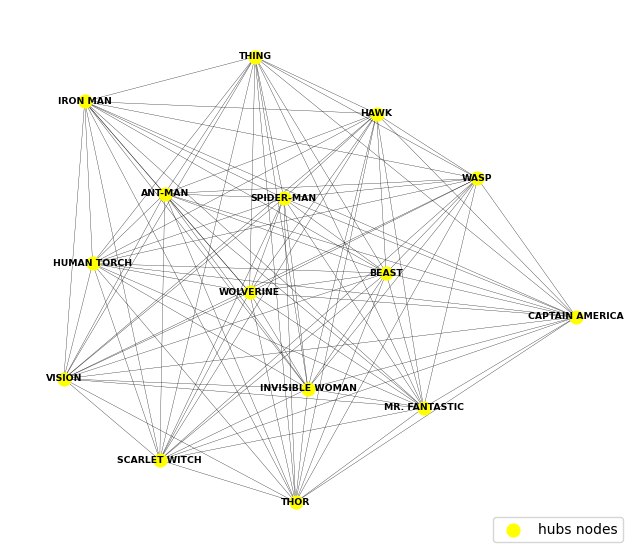


-->  The HUBS of the NETWORK :
	 total hubs = 15


HUBS  value
0              THOR     14
1              WASP     14
2              HAWK     14
3     MR. FANTASTIC     14
4   CAPTAIN AMERICA     14
5     SCARLET WITCH     14
6             BEAST     14
7   INVISIBLE WOMAN     14
8             THING     14
9       HUMAN TORCH     14
10          ANT-MAN     14
11         IRON MAN     14
12       SPIDER-MAN     14
13        WOLVERINE     14
14           VISION     14

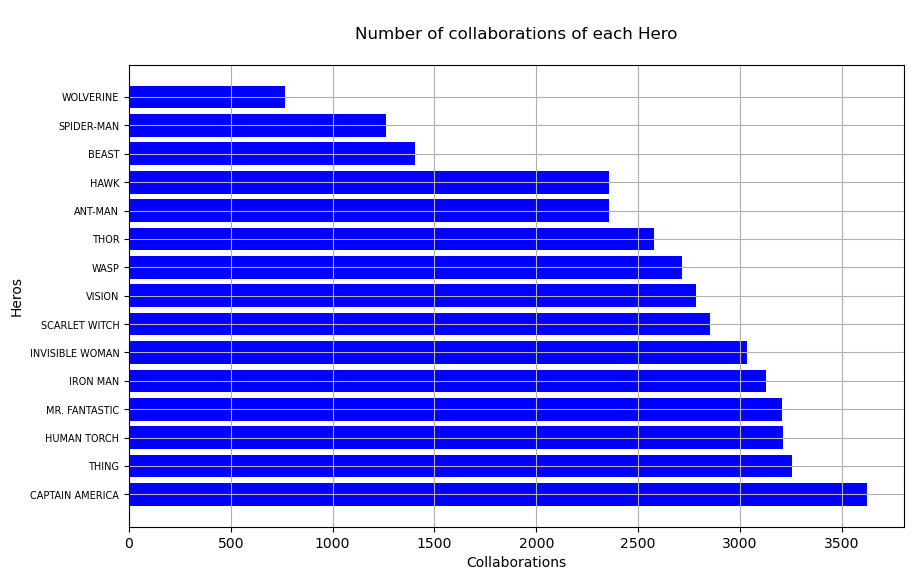


 DEGREE DISTRIBUTION OF THE NETWORK :



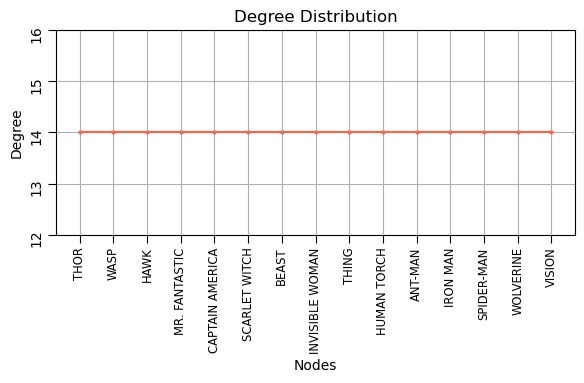

In [55]:
sub_graph, numeri, results, hubs, dist = funzione_1()

module.see_graph_1(sub_graph, hubs, lbl=True)
module.show_hubs(hubs)
module.Visualization1_graph1(results)
module.plot_degree(dist)

This Graph is made from the **top 15 Heroes**. It has yellow nodes for **Hubs** and blue for non-hub nodes.\
Hubs are nodes having degrees more extensive than the 95th percentile of the degree distribution

It is a **complete graph** → $density = 1$\
And its **average degree** is **14** → it means that each node in the network is connected to all the others.\
Note that the **degree distribution** is a **uniform** distribution.

Now let's raise the number of **heroes** to consider to **38** :

 - Graph type (1 or 2) :  1
 - Top N heroes that should be considered :  45


 
  sub-Graph with 45 nodes and 982 edges

╒═══════════════════╤══════════════════════════╤═════════════════════════════════╤══════════════════════╕
│  Number of Nodes  │  Density of the Network  │  Average Degree of the Network  │  is Sparse or Dense  │
╞═══════════════════╪══════════════════════════╪═════════════════════════════════╪══════════════════════╡
│        45         │          0.992           │             43.644              │        Dense         │
╘═══════════════════╧══════════════════════════╧═════════════════════════════════╧══════════════════════╛


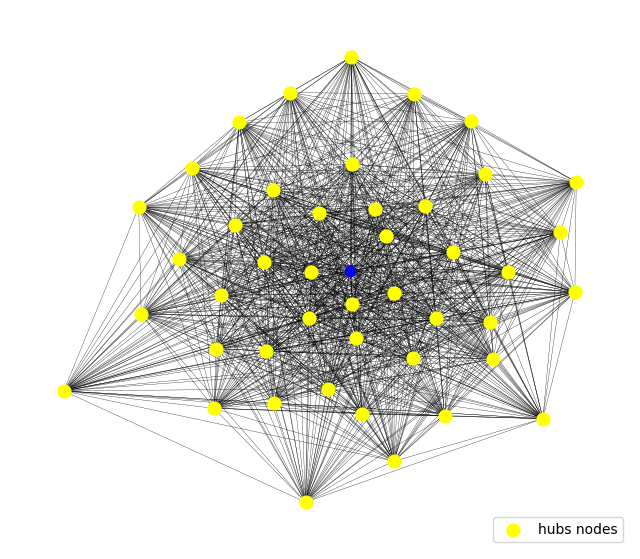


-->  The HUBS of the NETWORK :
	 total hubs = 44


HUBS  value
0             QUASAR III     44
1        INVISIBLE WOMAN     44
2                   HULK     44
3                  STORM     44
4            HUMAN TORCH     44
5                 ICEMAN     44
6            COLOSSUS II     44
7   HERCULES [GREEK GOD]     44
8          BLACK PANTHER     44
9              WOLVERINE     44
10         JARVIS, EDWIN     42
11            WONDER MAN     44
12                  WASP     44
13         MR. FANTASTIC     44
14       CAPTAIN AMERICA     44
15           QUICKSILVER     43
16                 THING     44
17           DR. STRANGE     44
18          NIGHTCRAWLER     44
19        BLACK KNIGHT V     43
20              IRON MAN     44
21            SPIDER-MAN     44
22              SHE-HULK     44
23     JAMESON, J. JONAH     43
24               CYCLOPS     44
25                VISION     44
26   FURY, COL. NICHOLAS     44
27           PROFESSOR X     44
28                  HAWK     44
29           SUB-MARINER     44
30           BLACK WIDOW     44
31                 ROGUE     44
32           MARVEL GIRL     44
33               ANT-MAN     44
34     CRYSTAL [INHUMAN]     44
35                  THOR     44
36                 ANGEL     44
37         SCARLET WITCH     44
38                  NOVA     43
39                 BEAST     44
40                 HAVOK     43
41             DAREDEVIL     44
42              PSYLOCKE     42
43             SHADOWCAT     41

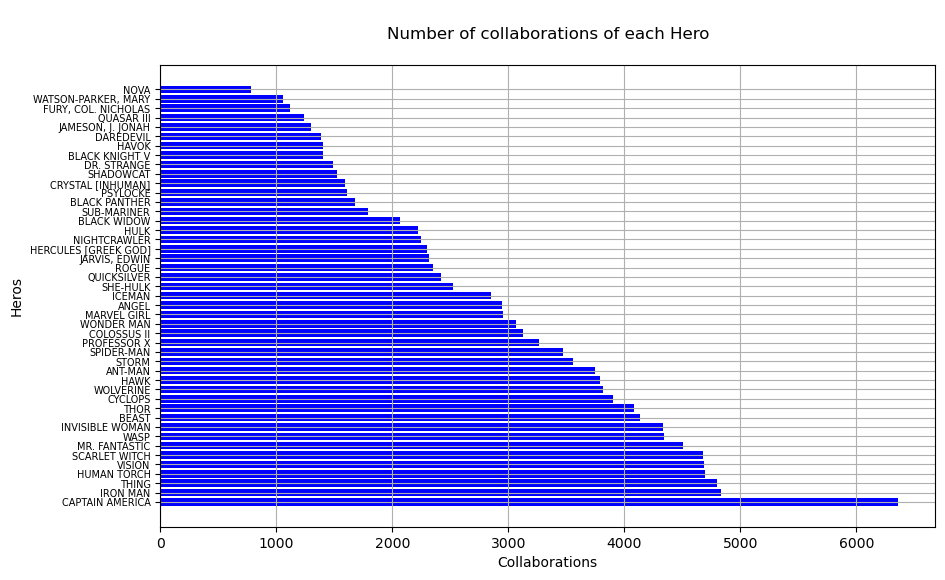


 DEGREE DISTRIBUTION OF THE NETWORK :



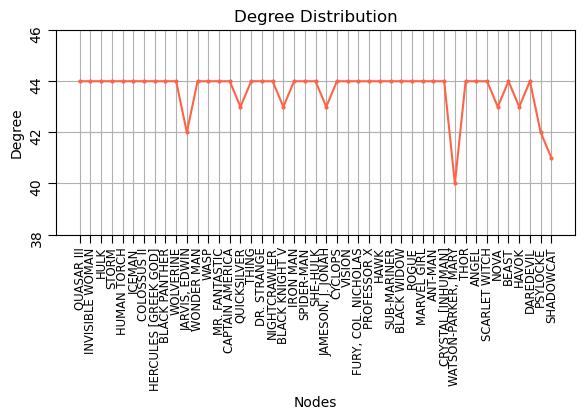

In [56]:
sub_graph, numeri, results, hubs, dist = funzione_1()

module.see_graph_1(sub_graph, hubs)
module.show_hubs(hubs)
module.Visualization1_graph1(results)
module.plot_degree(dist)            

-----------------------------------
Examples on the **Second Graph**:

Building the graph considering only the first **5 top heroes**

 - Graph type (1 or 2) :  2
 - Top N heroes that should be considered :  5


 
  sub-Graph with 841 nodes and 2191 edges
╒═══════════════════╤══════════════════════════╤═════════════════════════════════╤══════════════════════╕
│  Number of Nodes  │  Density of the Network  │  Average Degree of the Network  │  is Sparse or Dense  │
╞═══════════════════╪══════════════════════════╪═════════════════════════════════╪══════════════════════╡
│        841        │          0.006           │              5.21               │        Sparse        │
╘═══════════════════╧══════════════════════════╧═════════════════════════════════╧══════════════════════╛

-->  The HUBS of the NETWORK :
	 total hubs = 71


HUBS     value
0   CAPTAIN AMERICA  0.268526
1          IRON MAN  0.238176
2              THOR  0.211547
3             THING  0.097402
4        SPIDER-MAN  0.078144
..              ...       ...
66             A 94  0.000192
67            GAL 1  0.000192
68           FF 244  0.000192
69            FF 31  0.000192
70           FF3 28  0.000192

[71 rows x 2 columns]

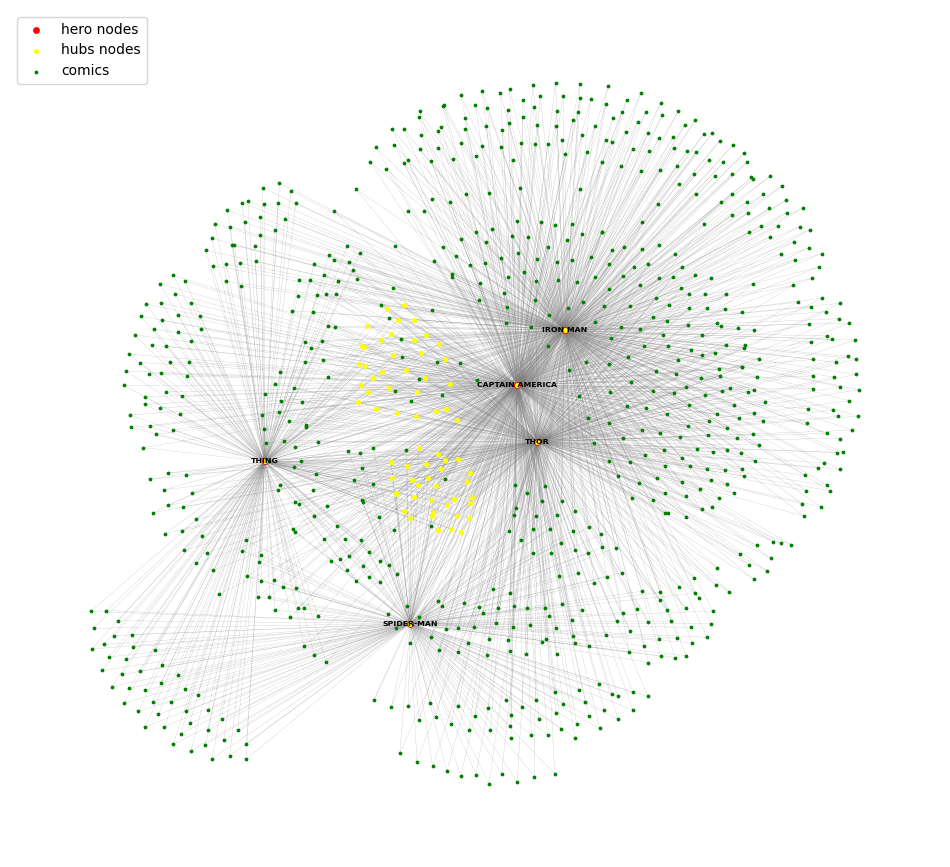


 DEGREE DISTRIBUTION:


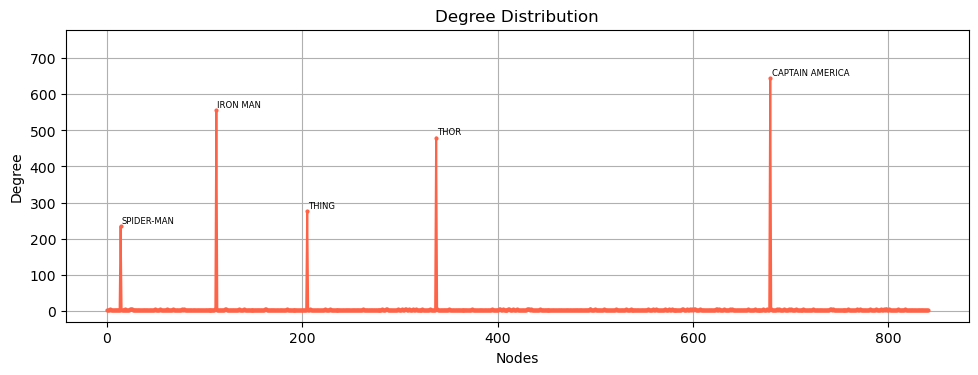

In [68]:
sub_graph, numeri, heroes_in_comic, hubs, dist = funzione_1()

module.show_hubs(hubs)
module.see_graph_2(sub_graph, hubs, jbl=True)
#module.Visualization1_graph2(heroes_in_comic)
module.plot_degree_2(dist)

Let's raise the number of **heroes** to consider to **30** :

 - Graph type (1 or 2) :  2
 - Top N heroes that should be considered :  25


 
  sub-Graph with 4156 nodes and 14970 edges
╒═══════════════════╤══════════════════════════╤═════════════════════════════════╤══════════════════════╕
│  Number of Nodes  │  Density of the Network  │  Average Degree of the Network  │  is Sparse or Dense  │
╞═══════════════════╪══════════════════════════╪═════════════════════════════════╪══════════════════════╡
│       4156        │          0.002           │              7.204              │        Sparse        │
╘═══════════════════╧══════════════════════════╧═════════════════════════════════╧══════════════════════╛

-->  The HUBS of the NETWORK :
	 total hubs = 208


HUBS     value
0              THING  0.003740
1        HUMAN TORCH  0.003719
2      MR. FANTASTIC  0.003654
3    CAPTAIN AMERICA  0.003590
4    INVISIBLE WOMAN  0.003443
..               ...       ...
203           AF 111  0.000626
204           FF 400  0.000623
205                M  0.000622
206            UX 14  0.000621
207            A 157  0.000617

[208 rows x 2 columns]

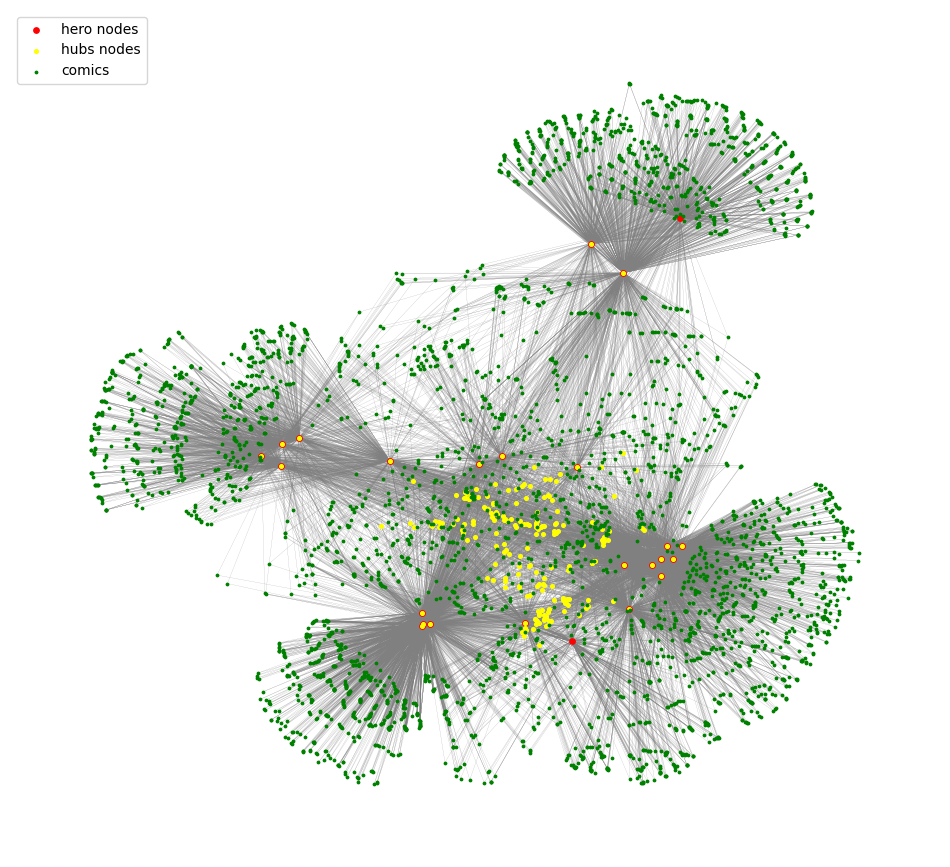


Comics considered for visualization : top 25 


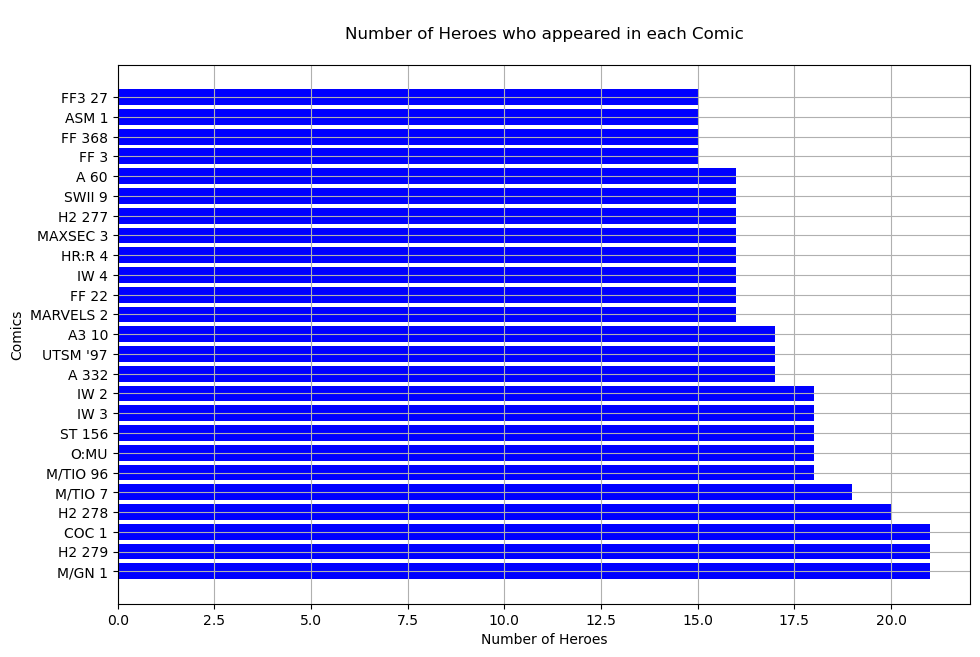

In [69]:
sub_graph, numeri, heroes_in_comic, hubs, dist = funzione_1()

module.show_hubs(hubs)
module.see_graph_2(sub_graph, hubs)
module.Visualization1_graph2(heroes_in_comic)
#module.plot_degree_2(dist)


 DEGREE DISTRIBUTION:


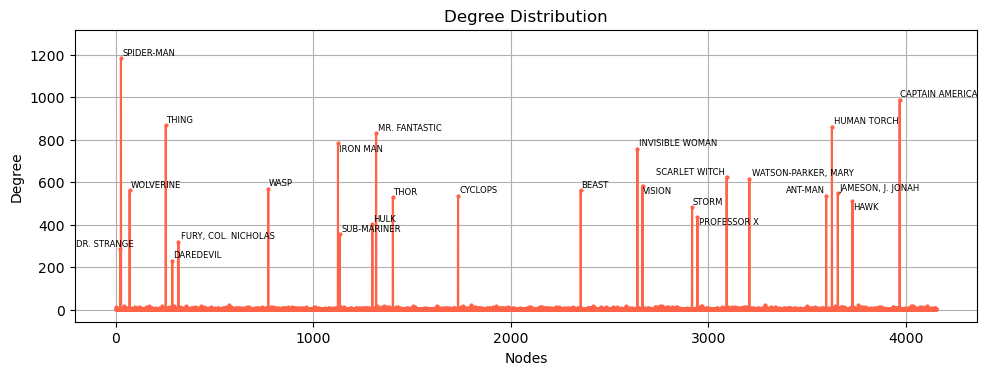

In [70]:
module.plot_degree_2(dist)

---------------------------
### Visualization 2 - Visualize Centrality Measures

To visualize the **Functionality_2** we use the following format:

A table containing the information related to the **requested centrality measure**: the average of the requested centrality measure for all of the network's nodes, the requested centrality measure's value for the given node.

In [60]:
def query_for_func2(G1,G2):
    
    avg, node_measure = ([] for i in range(2))
    measure=['Betweeness', 'PageRank', 'ClosenessCentrality', 'DegreeCentrality']   ## List containing all possible metrics
        
    g_type = int(input("\n - Graph type (1 or 2) : "))
    my_node = str(input(" - pick a node (hero or comic): "))
    N = int(input(" - Top N heroes that should be considered : "))
    graph_type = G1 if g_type == 1 else G2

    for i in tqdm(measure): ## For every possible metric
            
        cen_measure=func2(graph_type, my_node, i, n_heros, N)
            # calculate the mean of the dictionary values and insert the mean in the list avg
        mean=sum(cen_measure[0].values())/len(cen_measure[0])
        avg.append(round(mean,3))
            # insert the value of the metric on the node in the list node_measure
        if (type(cen_measure[1]) == float):
            node_measure.append(round(cen_measure[1],3))
        else:
            node_measure.append(cen_measure[1])

    print(" ")
    print(tabulate({'Measure': measure, 'Average_measure': avg, 'Node_measure': node_measure}, headers='keys', tablefmt='fancy_grid'))

In [61]:
query_for_func2(G_hero, G)  # example with first graph


 - Graph type (1 or 2) :  1
 - pick a node (hero or comic):  IRON MAN/TONY STARK
 - Top N heroes that should be considered :  50


100%|██████████| 4/4 [00:04<00:00,  1.02s/it]

 
╒═════════════════════╤═══════════════════╤════════════════╕
│ Measure             │   Average_measure │   Node_measure │
╞═════════════════════╪═══════════════════╪════════════════╡
│ Betweeness          │             0.031 │          0.002 │
├─────────────────────┼───────────────────┼────────────────┤
│ PageRank            │             0.02  │          0.009 │
├─────────────────────┼───────────────────┼────────────────┤
│ ClosenessCentrality │            65.718 │         89.168 │
├─────────────────────┼───────────────────┼────────────────┤
│ DegreeCentrality    │             0.975 │          1     │
╘═════════════════════╧═══════════════════╧════════════════╛


In [62]:
query_for_func2(G_hero, G)   # example with second graph


 - Graph type (1 or 2) :  2
 - pick a node (hero or comic):  COC 1
 - Top N heroes that should be considered :  7


100%|██████████| 4/4 [01:55<00:00, 28.88s/it]

 
╒═════════════════════╤═══════════════════╤════════════════╕
│ Measure             │   Average_measure │   Node_measure │
╞═════════════════════╪═══════════════════╪════════════════╡
│ Betweeness          │             0.001 │          0.002 │
├─────────────────────┼───────────────────┼────────────────┤
│ PageRank            │             0.001 │          0.001 │
├─────────────────────┼───────────────────┼────────────────┤
│ ClosenessCentrality │             0.381 │          0.501 │
├─────────────────────┼───────────────────┼────────────────┤
│ DegreeCentrality    │             0.004 │          0.005 │
╘═════════════════════╧═══════════════════╧════════════════╛


In [63]:
# HULK/DR. ROBERT BRUC , DR. STRANGE/STEPHEN , IRON MAN/TONY STARK, COC 1, FF 23

---------------------------
### Visualization 3 - Visualize the Shortest-ordered Route

This algorithm should be run only on the second graph.

Here are the comics in the shortest walk in order :

In [64]:
#h = ['DR. STRANGE/STEPHEN', 'BEAST/HENRY &HANK& P', 'ICEMAN/ROBERT BOBBY',"FURY, COL. NICHOLAS"]
h = ['DR. STRANGE/STEPHEN', 'BEAST/HENRY &HANK& P', 'INVISIBLE WOMAN/SUE']

q_hero_1 = 'THOR/DR. DONALD BLAK'
q_hero_2 = 'IRON MAN/TONY STARK'      #'DAREDEVIL/MATT MURDO'

N = 20

c_list, n_list = func3(G, h, q_hero_1 ,q_hero_2 , n_heros, N)
sub_graph, _ = top_hero_from_graph2(edges, G, N, p=None)
sub_sub = sub_graph.subgraph(n_list)

print('\nThese are the comics in the shortest walk:', c_list )

  sub-Graph with 3570 nodes and 12287 edges

These are the comics in the shortest walk: ['A 115', 'A 157', 'A 13', 'A 1']


Graph with 9 nodes and 13 edges


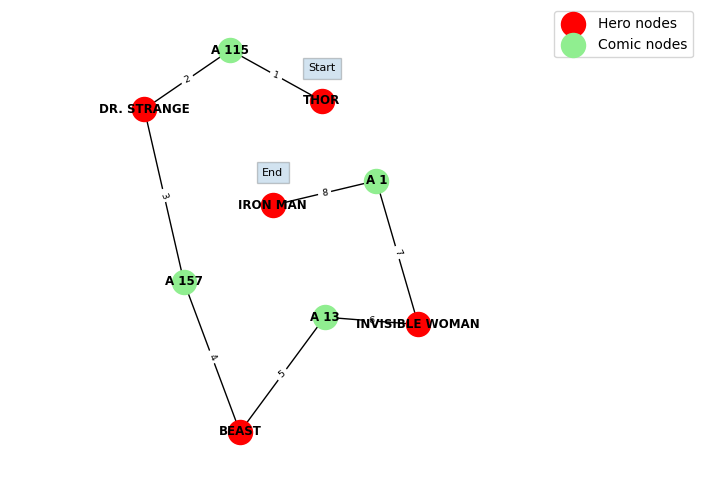

In [65]:
print(nx.info(sub_sub))
module.plot_path(n_list, sub_sub)

Graph with 3570 nodes and 12287 edges


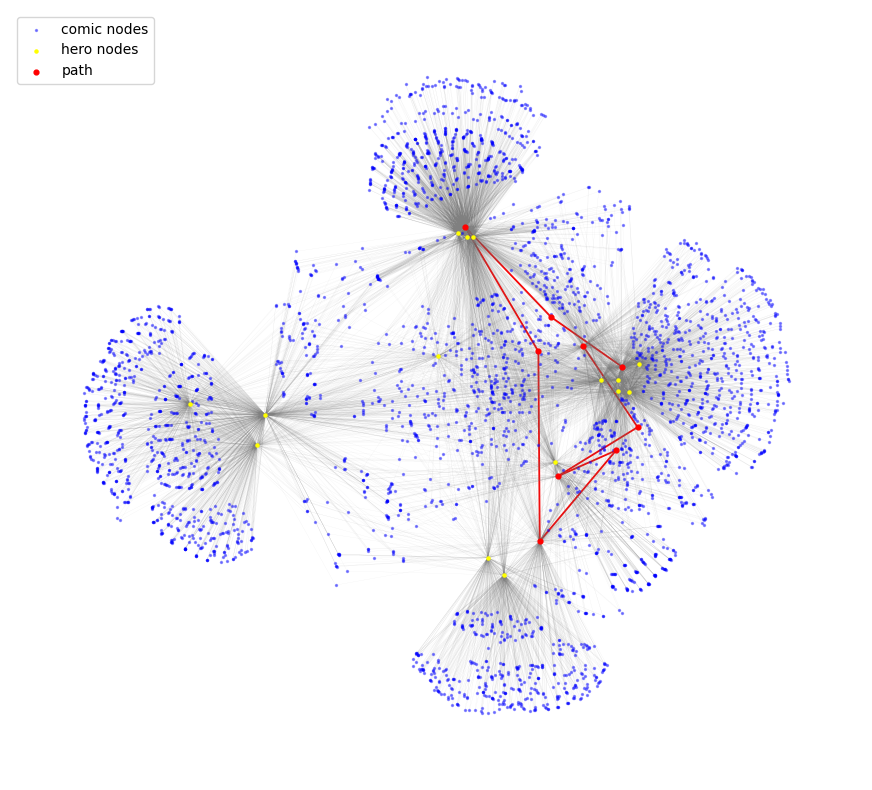

In [66]:
print(nx.info(sub_graph))
module.short_path(n_list, sub_graph)

------------------------------
### Visualization 5 - Visualize the Communities

This functionality should only be run on the first graph

  sub-Graph with 25 nodes and 300 edges

 
IRON MAN/TONY STARK and CAPTAIN AMERICA  →  belongs to the same community

The minimum number of edges that should be removed to form communities : 24


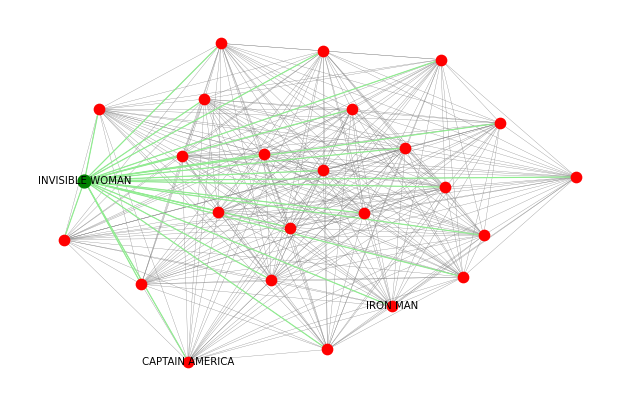


 INVISIBLE WOMAN  is the only HERO that's part of a separate community
 
Main Community list : 



Community
0      ANGEL/WARREN KENNETH
1      ANT-MAN/DR. HENRY J.
2      BEAST/HENRY &HANK& P
3           CAPTAIN AMERICA
4      COLOSSUS II/PETER RA
5      CYCLOPS/SCOTT SUMMER
6       DR. STRANGE/STEPHEN
7                      HAWK
8      HULK/DR. ROBERT BRUC
9      HUMAN TORCH/JOHNNY S
10      IRON MAN/TONY STARK
11     MARVEL GIRL/JEAN GRE
12     MR. FANTASTIC/REED R
13      PROFESSOR X/CHARLES
14      SCARLET WITCH/WANDA
15     SHE-HULK/JENNIFER WA
16  SPIDER-MAN/PETER PARKER
17     STORM/ORORO MUNROE S
18     THING/BENJAMIN J. GR
19     THOR/DR. DONALD BLAK
20                   VISION
21      WASP/JANET VAN DYNE
22          WOLVERINE/LOGAN
23     WONDER MAN/SIMON WIL

In [67]:
sub, result, ldict= funzione_5(G_hero, 25, "IRON MAN/TONY STARK","CAPTAIN AMERICA")

module.visualization_f5(sub, result, ldict)